## Imports and Setup

In [1]:
import os
import pandas as pd
import geopandas as gpd
import logging
import torch

import sys
sys.path.insert(0, "../utils/")
import model_utils
import config_utils
import embed_utils

%load_ext autoreload
%autoreload 2

## Data Configurations

In [9]:
iso_code = "MNG"
cwd = os.path.dirname(os.getcwd())
config_file = os.path.join(cwd, f"configs/model_configs/{iso_code}-dinov2_vits14-LR.yaml")
config = config_utils.load_config(config_file)

## Load Model

In [3]:
model = torch.hub.load("facebookresearch/dinov2", config["embed_model"])
model.name = config["embed_model"]
device = torch.device('cuda' if torch.cuda.is_available() else "cpu")
model.to(device)

Using cache found in /home/itingzon.unicef/.cache/torch/hub/facebookresearch_dinov2_main
/home/itingzon.unicef/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/home/itingzon.unicef/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/home/itingzon.unicef/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")
INFO:dinov2:using MLP layer as FFN


DinoVisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 384, kernel_size=(14, 14), stride=(14, 14))
    (norm): Identity()
  )
  (blocks): ModuleList(
    (0-11): 12 x NestedTensorBlock(
      (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (attn): MemEffAttention(
        (qkv): Linear(in_features=384, out_features=1152, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=384, out_features=384, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): LayerScale()
      (drop_path1): Identity()
      (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=384, out_features=1536, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=1536, out_features=384, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
      (ls2): LayerScale()
      (drop_path2): Identity()
    )
  )
  (n

## Load Data

In [11]:
data = model_utils.load_data(config, attributes=["rurban", "iso"], verbose=True)
data.head(3)

INFO:root:Reading file /home/itingzon.unicef/giga/data/vectors/train/MNG_train.geojson
INFO:root:
  rurban  iso       class  count  percentage
0  rural  MNG  non_school    817    0.273519
1  rural  MNG      school    354    0.118514
2  urban  MNG  non_school   1380    0.462002
3  urban  MNG      school    436    0.145966
INFO:root:
                               count  percentage
rurban iso class      dataset                   
rural  MNG non_school test       159    0.266332
                      train      658         NaN
           school     test        75    0.125628
                      train      279         NaN
urban  MNG non_school test       274    0.458961
                      train     1106         NaN
           school     test        88    0.147404
                      train      348         NaN
INFO:root:
                    count
dataset class            
test    non_school    433
        school        163
train   non_school   1764
        school        627
INFO:root

None


,UID,source,iso,country,region,subregion,name,giga_id_school,clean,validated,class,ghsl_smod,rurban,dataset,geometry
0,OVERTURE-MNG-SCHOOL-00000005,OVERTURE,MNG,Mongolia,Asia,Eastern Asia,ЭРХЭТ ЭРДЭМ сургууль,None,0,0.0,school,30,urban,train,POINT (8344756.737 5653710.189)
1,OVERTURE-MNG-SCHOOL-00000006,OVERTURE,MNG,Mongolia,Asia,Eastern Asia,"Үндэсний лаборатори ""Ган зам"" 20-р сургууль",None,0,0.0,school,30,urban,train,POINT (8347054.679 5653227.958)
2,OVERTURE-MNG-SCHOOL-00000018,OVERTURE,MNG,Mongolia,Asia,Eastern Asia,Олонлог Академи Сургууль,None,0,0.0,school,30,urban,train,POINT (8352597.460 5652028.616)


## Urban Schools

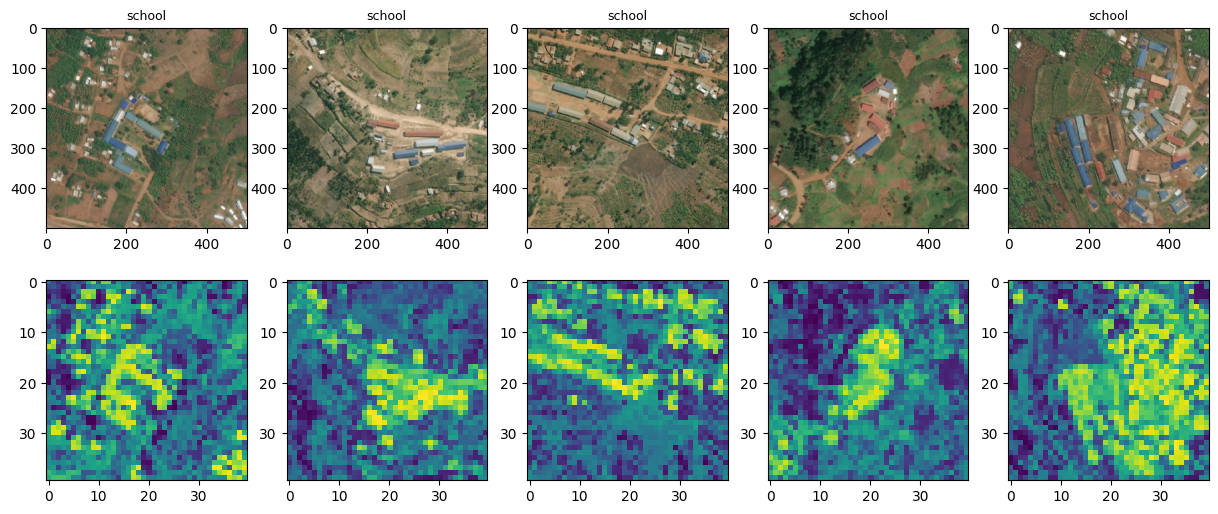

In [11]:
subdata = data[(data.rurban=="urban") & (data["class"] == "school")]
embed_utils.visualize_embeddings(config, subdata, model, batch_size=5)

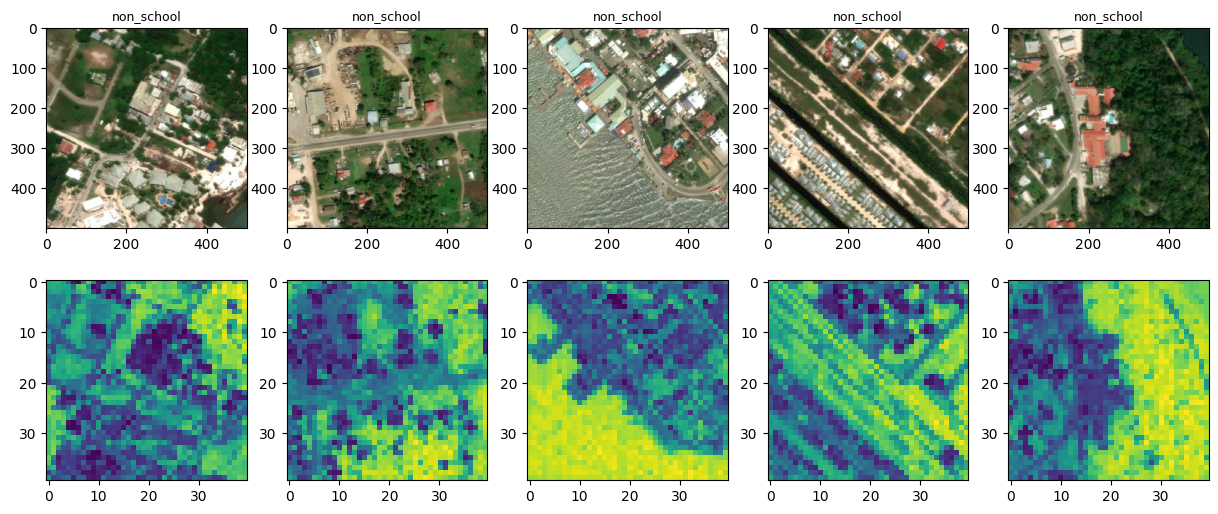

In [6]:
subdata = data[(data.rurban=="urban") & (data["class"] == "non_school")]
embed_utils.visualize_embeddings(config, subdata, model, batch_size=5)

## Rural Schools

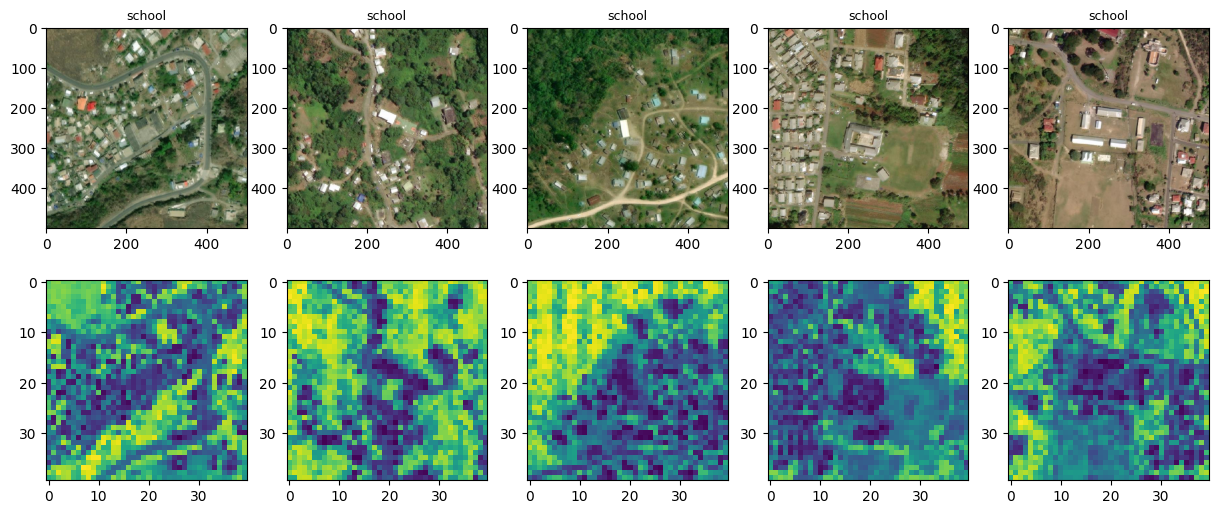

In [39]:
subdata = data[(data.rurban=="rural") & (data["class"] == "school")]
embed_utils.visualize_embeddings(config, subdata, model, batch_size=5)

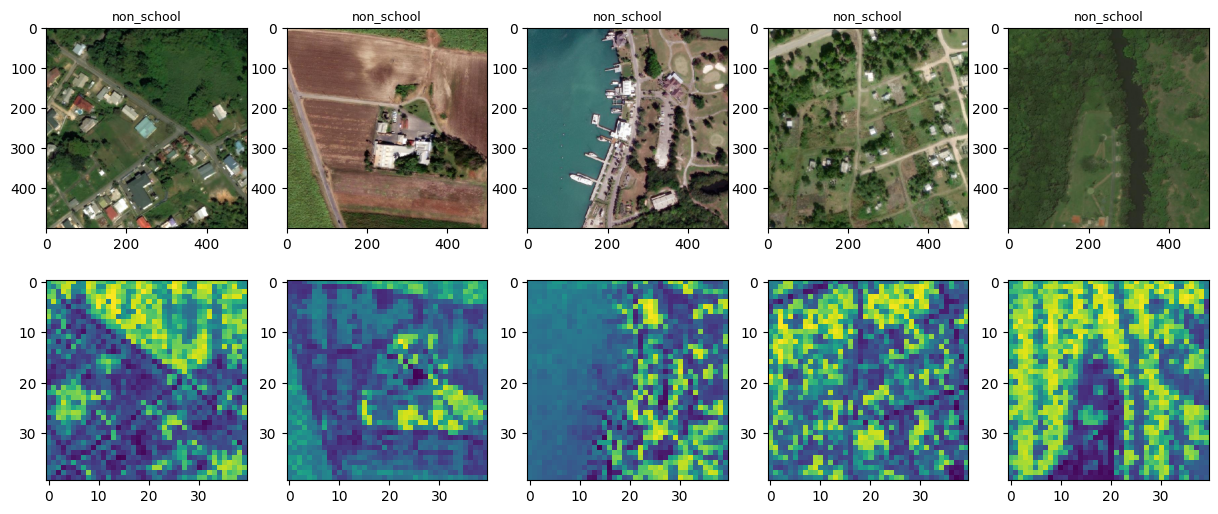

In [40]:
subdata = data[(data.rurban=="rural") & (data["class"] == "non_school")]
embed_utils.visualize_embeddings(config, subdata, model, batch_size=5)

## Compute Embeddings

In [ ]:
embeddings = embed_utils.compute_embeddings(config, data, model)
embeddings.head(3)